# Implementation 
Author: Antonio Baiano Svizzero

In this tutorial, you will learn how to: 
- Define acoustic velocity and impedance boundary conditions
- Compute acoustic sound pressure for multiple frequencies
- Compute the Sound Pressure Level (SPL) at a given microphone position

## Test problem
As an example, we will model a plane wave propagating in a tube. While it is a basic test case, the code can be adapted to way more complex problems where velocity and impedance boundary conditions are needed. 
We will apply a velocity boundary condition $v_n = 0.001$ to one end of the tube and an impedance $Z$ computed with the Delaney-Bazley model, supposing that a layer of thickness $d = 0.02$ and flow resistivity $\sigma = 1e4$ is placed at the second end of the tube. The choice of such impedance (the one of a plane wave propagating in free field) will give, as a result, a solution with no reflections. 

First, we create the mesh with gmsh, also setting the physical group for velocity and impedance boundary conditions and the respective tags.

In [2]:
import gmsh

gmsh.initialize()

# meshsize settings
meshsize = 0.02
gmsh.option.setNumber("Mesh.MeshSizeMax", meshsize)
gmsh.option.setNumber("Mesh.MeshSizeMax", meshsize)


# create geometry
L = 1
W = 0.1

gmsh.model.occ.addBox(0, 0, 0, L, W, W)
gmsh.model.occ.synchronize()

# setup physical groups
v_bc_tag = 2
Z_bc_tag = 3
gmsh.model.addPhysicalGroup(3, [1], 1, "air_volume")
gmsh.model.addPhysicalGroup(2, [1], v_bc_tag, "velocity_BC")
gmsh.model.addPhysicalGroup(2, [2], Z_bc_tag , "impedance")

# mesh generation
gmsh.model.mesh.generate(3)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000750003s, CPU 0.001139s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0316326s

Then we import the gmsh mesh with the ```dolfinx.io.gmshio``` function and define the functionspace

In [3]:
from dolfinx import mesh, fem, plot, io, default_scalar_type, geometry
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np

# frequency axis 
freq = np.arange(10,1000,5) # Hz

# Air parameters
rho0 = 1.225 # kg/m^3
c   = 340   # m/s

mesh, cell_tags, facet_tags= io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=3)
V = fem.functionspace(mesh, ("Lagrange", 1))

[antonio-bayswiss:124289] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.antonio-bayswiss.1000/jf.0/3500670976/shared_mem_cuda_pool.antonio-bayswiss could be created.
[antonio-bayswiss:124289] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


## Boundary conditions

The Delaney-Bazley model is used to compute the characteristic impedance and wavenumber of the porous layer, treated as an equivalent fluid with complex valued properties

$
\begin{align}
Z_c(\omega) = \rho_0 c_0 \left[1 + 0.0571 X^{-0.754} - j 0.087 X^{-0.732}\right].
\end{align}
$

$
\begin{align}
k_c(\omega) = \frac{\omega}{c_0} \left[1 + 0.0978 X^{-0.700} - j 0.189 X^{-0.595}\right].
\end{align}
$

where $X = \frac{\rho_0 f}{\sigma}$

With these, we can compute the surface impedance, that in the case of a rigid passive absorber placed on a rigid wall is given by the formula 
$
\begin{align}
Z_s = -j Z_c cot(k_c d)
\end{align}
$

Let's create a function to compute it. 



In [30]:
# Impedance calculation
def delany_bazley_layer(f, rho0, c, sigma):

    X = rho0*f/sigma
    Zc = rho0*c*(1+0.0571*X**-0.754 - 1j * 0.087*X**-0.732)
    kc = 2*np.pi*f/c*(1+0.0978*(X**-0.700) - 1j*0.189*(X**-0.595))

    Z_s = -1j * Zc * (1/np.tan(kc * d))
    return Z_s

sigma = 1.5e4 
d = 0.01
Z_s     = delany_bazley_layer(freq,rho0,c,sigma)

Since we are going to compute a sound pressure spectrum, all the variables that depend on frequency (that are $\omega$, $k$ and $Z$)  need to be updated in the frequency loop. To make this possible, we will initialize them as dolfinx constants. Then, we define the value for the normal velocity on the first end of the tube

In [31]:
omega = fem.Constant(mesh, default_scalar_type(0))
k    = fem.Constant(mesh, default_scalar_type(0))
Z = fem.Constant(mesh, default_scalar_type(0))
v_n = 1e-5

We also need to specify the integration measure $ds$, by using ```ufl```, and its built in integration measures

In [32]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tags)

## Variational Formulation
We can now write the variational formulation.

In [39]:
p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(ufl.grad(p),ufl.grad(v)) * ufl.dx   + 1j * rho0 * omega / Z * ufl.inner(p,v) * ds(Z_bc_tag) - k**2 * ufl.inner(p,v)* ufl.dx
L = - 1j * omega * rho0 * ufl.inner(v_n, v) * ds(v_bc_tag)

The class ```LinearProblem``` is used to setup the PETSc backend and assemble the system vector and matrices. The solution will be stored in a dolfinx function, ```p_a```.

In [40]:
p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(a, L, u=p_a, petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})

## Computing the pressure at a given location
Before starting our frequency loop, we can build a function that, given a microphone position, computes the sound pressure at its location. We will use the same script seen in [Deflection of a membrane](../chapter1/membrane_code)

In [50]:
def mic_pressure(mic):
    points = np.zeros((3,1))

    points[0][0] = mic[0]
    points[1][0] = mic[1]
    points[2][0] = mic[2]

    bb_tree_ = geometry.bb_tree(mesh, mesh.topology.dim)
    cells = []
    points_on_proc = []

    cell_candidates = geometry.compute_collisions_points(bb_tree_, points.T)
    colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)

    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    
    if len(cells) > 0:
        p_values = p_a.eval(points_on_proc, cells)
    else: 
        p_values = None
    return p_values

The pressure spectrum is initialized as a numpy array and the microphone location is assigned

In [51]:
p_mic = np.zeros((len(freq),1),dtype=complex)

mic = np.array([0.5, 0.05, 0.05])

## Frequency loop

Finally, we can write the frequency loop, where we update the values of the frequency-dependent variables and solve the system for each frequency

In [52]:
for nf in range(0,len(freq)):

    k.value = 2*np.pi*freq[nf]/c
    omega.value = 2*np.pi*freq[nf]
    Z.value     = Z_s[nf]

    problem.solve()
    p_a.x.scatter_forward()
    
    p_f = mic_pressure(mic)
    p_f = mesh.comm.gather(p_f, root=0)

    if mesh.comm.rank == 0:
        for pressure in p_f:
            if pressure is not None: 
                p_mic[nf] = pressure

## SPL spectrum
After the computation, the pressure spectrum at the prescribed location is available. Such a spectrum is usually shown using the decibel (dB) scale to obtain the SPL, with the RMS pressure as input, defined as $p_{rms} = \frac{p}{\sqrt{2}}$. 

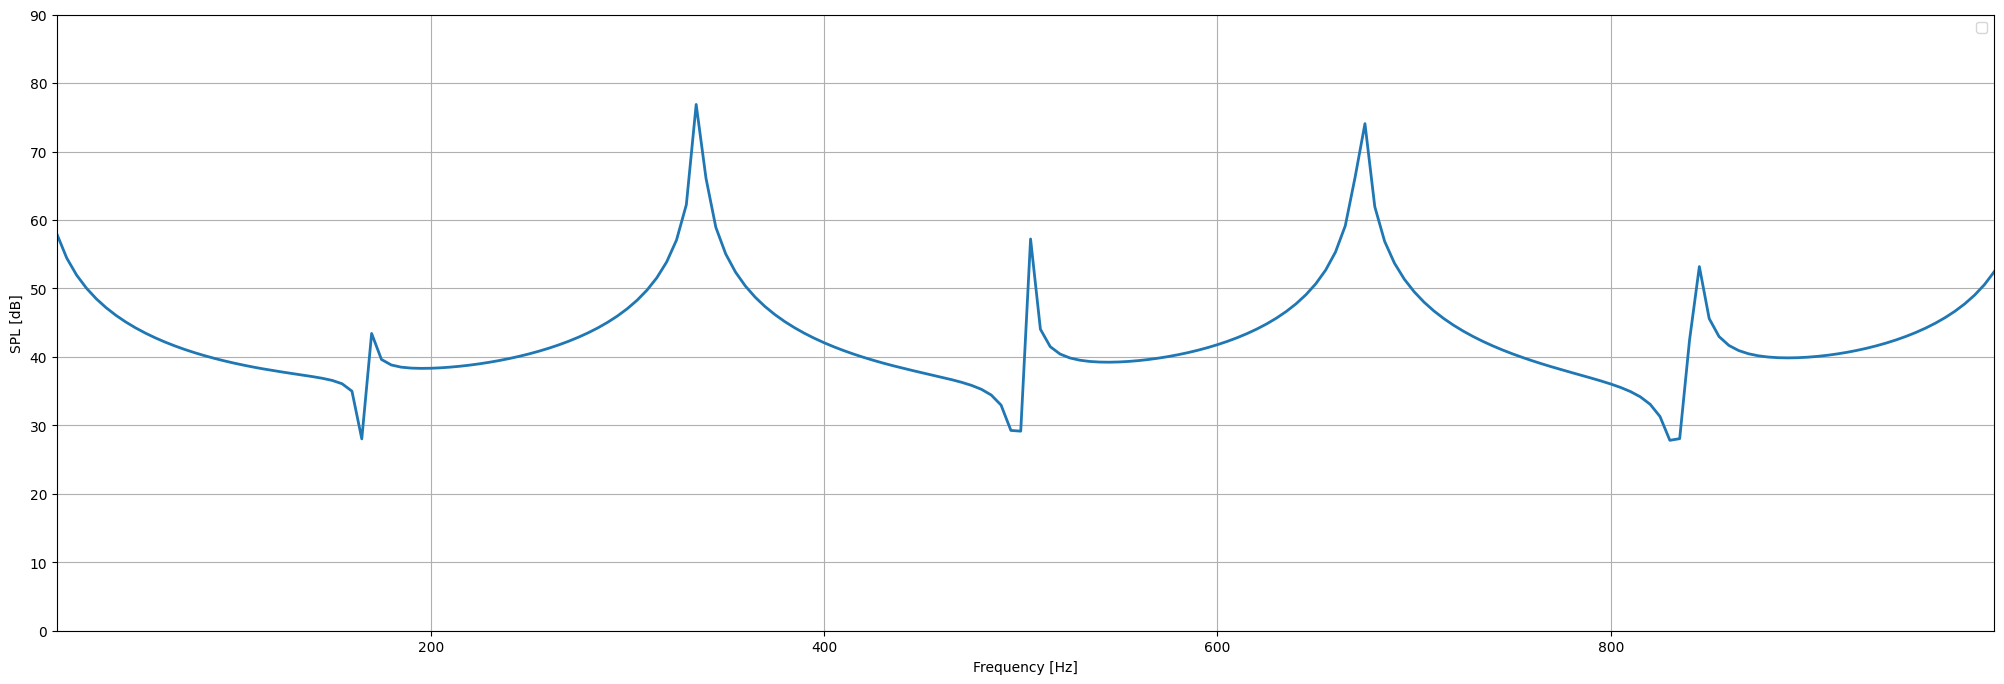

In [53]:
if mesh.comm.rank == 0:
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(25, 8))
    plt.plot(freq, 20*np.log10(np.abs(p_mic)/np.sqrt(2)/2e-5), linewidth=2)
    plt.grid(True)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("SPL [dB]")
    plt.xlim([freq[0],freq[-1]])
    plt.ylim([0,90])
    plt.legend()
    plt.show()